# Reinforcement Learning from Scratch Part 1: Finding the Optimal Policy of an Environment Fully Defined within a Python Notebook

## Solving an Example Task of Throwing Paper into a Bin


This notebook attempts to solve a basic task of throwing paper into a bin using reinforcement learning. In this problem, we may throw from any position in the room but the probability of it is relative to the current distance from the bin and the direction in which the paper is thrown. Therefore the actions available are to throw the paper in any 360 degree direction or move to a new position to try and increase the probability that a throw made will go into the bin.

We first introduce the problem where the bin's location is known and can be solved directly with Value-Itearation methods before showing how RL can be used similarly to find the optimal policy if the probabilities are hidden in later notebooks.

Furthermore, we introduce the option to add control to the environment where, for example, we can punish the algorithm less for missed throws so that the algorithm will take higher risks.

Lastly, we demonstrate how the envrionment can be changed and, for example, may have walls blocking throws from certain positions. 

I will also be publishing an accompanying article explaining the process without code that can be found on my website or Medium page:

https://www.philiposbornedata.com/

https://medium.com/@philiposbornedata



## Part 1: Defining the Environment

The environment's probabilities are calcualted based on the direction in which the paper is thrown and the current distance from the bin. 

For example, in the image below we have three people labelled A, B and C. A and B both throw in the correct direction but person A is closer than B and so will have a higher probability of landing the shot. 

Person C is closer than person B but throws in the completely wrong direction and so will have a very low probability of hitting the bin. This may seem illogical that person C would throw in this direction but, as we will show more later, an algorithm has to try a range of directions first to figure out where the successes are and will have no visual guide as to where the bin is. 




![Enironment Demo](https://i.imgur.com/3woVbKI.png)

To create the environment in python, we convert the diagram into 2-d dimensions of x and y values and use bearing mathematics to calculate the angles thrown. We used normalised x and y values so that they must be between 0 and 10 (or 0 and -10) as whole numbers.


### 1.1 Distance Measure
We can plot this and show person's A position in this definition to be (-0.5,-0.5). This is their current state and their distance from the bin can be calculated using the Euclidean distance measure:

\begin{equation}
 distance(State,Bin) = \sqrt{(State_x-Bin_x)^2 + (State_y-Bin_y)^2}
\end{equation}

and in our case, we have:

\begin{equation}
 distance(A, Bin) = \sqrt{(-0.5-0)^2 + (-0.5-0)^2} = \sqrt{0.5} \approx 0.7071
\end{equation}

For the final calcualtions, we normalise this and reverse the value so that a high score indicates that the person is closer to the target bin:


\begin{equation}
 distance\_score(State, Bin) = 1-\frac{distance(State,Bin)}{Max\_dist(State,Bin)} 
\end{equation}

Because we have fixed our 2-d dimensions between (-1, 1), the max posssible distance the person could be is $ \sqrt{(1) + (1)} = \sqrt{2}$ from the bin. Therefore our distance score for person A is:

\begin{equation}
 distance\_score(A, Bin) = 1-\frac{\sqrt{0.5}}{\sqrt{2}} = 1 - 0.5 = 0.5
\end{equation}


### 1.2 Direction Measure

Person A then has a decision to make, do they move or do they throw in a chosen direction. For now, let imagine they choose to throw the paper, their first throw is at 50 degrees and the second is 60 degrees from due north. The direction of the bin from person A can be calculated by simple trigonometry:


\begin{equation}
 direction(A, bin) = tan^{-1}(0.5/0,5) = 45 \ degrees
\end{equation}

Therefore, the first throw is 5 degrees off the true direction and the second is 15 degrees.

When we consider that good throws are bounded by 45 degrees either side of the actual direction (i.e. not throwing the wrong way) then we can use the following to calculate how good this chosen direction is. Any direction beyond the 90 degress will produce a negative value and be mapped to probability of 0:

\begin{equation}
 dir\_score(State, Throw\_action) =  \frac{45 - |True\_dir - Actual\_dir|}{45}  
\end{equation}

\begin{equation}
 dir\_score(A, Throw_1) = \frac{ 45 - |45 - 50|}{45} \approx 0.8889
\end{equation}

\begin{equation}
 dir\_score(A, Throw_2) =  \frac{45 - |45 - 60|}{45} \approx 0.6667  
\end{equation}


Both are fairly close but their first throw is more likely to hit the bin. 

### 1.3 Probability Calculation

We therefore calculate our probability of a successful throw to be relative to both these measures:


\begin{equation}
 prob\_success(State, Throw\_action) = distance\_score*dir\_score  
\end{equation}


Which we have for person A's first throw to be:


\begin{equation}
 prob\_success(A, Throw_1) = 0.5*0.9722 \approx 0.4444  
\end{equation}

and the second to be:

\begin{equation}
 prob\_success(A, Throw_1) = 0.5*0.9167 \approx 0.3333
\end{equation}


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

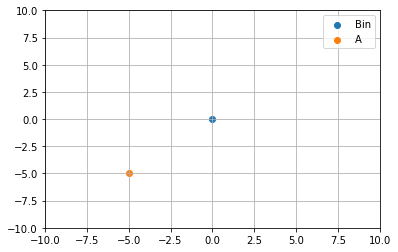

In [2]:

bin_x = 0
bin_y = 0

starting_position_x = -5
starting_position_y = -5

plt.scatter(bin_x, bin_y, label = "Bin")
plt.scatter(starting_position_x, starting_position_y, label = "A")
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.grid()
plt.legend()
plt.show()

To make things easier for continuous runs, we combine these calculations into a single function. The distance score is calcualted as before and we make sure to account for a bin being placed is other locations.

The direction score calculations are a little harder to generalise. In our example person A is south-west from the bin and therefore the angle was a simple calculation but if we applied the same to say a person placed north-east then this would be incorrect. Furthermore, because the bin can be placed anywhere we need to first find where the person is relative to this, not just the origin, and then used to to establish to angle calcuation required. 

This is summarised in the diagram below where we have generalised each of the trignomertric calculations based on the person's relative position to the bin:

![Imgur](https://i.imgur.com/lCNiiwf.png)

### 1.4 Probability Function 

With this diagram in mind, we create a function that calculates the probability of a throw's success from only given position relative to the bin.

First, if the position is the same as the bin (i.e. the person is directly inside the bin already) then the probability is fixed to 100%. 

Next, we have to re-define the throwing direction in two cases to accomodate for the fact that 360 degrees is the same as 0 degrees. For example, if we are south-west of the bin and throw 350 degrees, this would be the same as -10 degrees and would then relate to a bearing from the person to the bin less than 90 correctly.

Then the euclidean distance is calculated followed by the max distance a person could be from the bin.

We then calculate the bearing from the person to the bin following the previous figure and calcualte the score bounded within a +/- 45 degree window. Throws that are closest to the true bearing score higher whilst those further away score less, anything more than 45 degrees (or less than -45 degrees) are negative and then set to a zero probability. 

Lastly, the overall probability is related to both the distance and direction given the current position. 

In [3]:
import pandas as pd
import numpy as np

In [4]:

def probability(bin_x, bin_y, state_x, state_y, throw_deg):


    #First throw exception rule if person is directly on top of bin:
    if((state_x==bin_x) & (state_y==bin_y)):
        probability = 1
    else:
        
        
        # To accomodate for going over the 0 degree line
        if((throw_deg>270) & (state_x<=bin_x) & (state_y<=bin_y)):
            throw_deg = throw_deg - 360
        elif((throw_deg<90) & (state_x>bin_x) & (state_y<bin_y)):
            throw_deg = 360 + throw_deg
        else:
            throw_deg = throw_deg
            
        # Calculate Euclidean distance
        distance = ((bin_x - state_x)**2 + (bin_y - state_y)**2)**0.5

        # max distance for bin will always be on of the 4 corner points:
        corner_x = [-10,-10,10,10]
        corner_y = [-10,10,-10,10]
        dist_table = pd.DataFrame()
        for corner in range(0,4):
            dist = pd.DataFrame({'distance':((bin_x - corner_x[corner])**2 + (bin_y - corner_y[corner])**2)**0.5}, index = [corner])
            dist_table = dist_table.append(dist)
        dist_table = dist_table.reset_index()
        dist_table = dist_table.sort_values('distance', ascending = False)
        max_dist = dist_table['distance'][0]
        
        distance_score = 1 - (distance/max_dist)


        # First if person is directly horizontal or vertical of bin:
        if((state_x==bin_x) & (state_y>bin_y)):
            direction = 180
        elif((state_x==bin_x) & (state_y<bin_y)):
             direction = 0
        
        elif((state_x>bin_x) & (state_y==bin_y)):
             direction = 270
        elif((state_x<bin_x) & (state_y==bin_y)):
             direction = 90
              
        # If person is north-east of bin:
        elif((state_x>bin_x) & (state_y>bin_y)):
            opp = abs(bin_x - state_x)
            adj = abs(bin_y - state_y)
            direction = 180 +  np.degrees(np.arctan(opp/adj))

        # If person is south-east of bin:
        elif((state_x>bin_x) & (state_y<bin_y)):
            opp = abs(bin_y - state_y)
            adj = abs(bin_x - state_x)
            direction = 270 +  np.degrees(np.arctan(opp/adj))

        # If person is south-west of bin:
        elif((state_x<bin_x) & (state_y<bin_y)):
            opp = abs(bin_x - state_x)
            adj = abs(bin_y - state_y)
            direction =  np.degrees(np.arctan(opp/adj))

        # If person is north-west of bin:
        elif((state_x<bin_x) & (state_y>bin_y)):
            opp = abs(bin_y - state_y)
            adj = abs(bin_x - state_x)
            direction = 90 +  np.degrees(np.arctan(opp/adj))

        direction_score = (45-abs(direction - throw_deg))/45
      
        probability = distance_score*direction_score
        if(probability>0):
            probability = probability
        else:
            probability = 0
        
    return(probability)
    
    
    


If we use this to calculate the previous examples, we find the same results:

In [5]:
bin_x = 0
bin_y = 0

starting_position_x = -5
starting_position_y = -5

test_1 = probability(bin_x, bin_y, starting_position_x, starting_position_y, 50)
test_2 = probability(bin_x, bin_y, starting_position_x, starting_position_y, 60)

In [6]:
print("Probability of first throw at 50 degrees = ", np.round(test_1,4))
print("Probability of second throw at 60 degress = ", np.round(test_2,4))

Probability of first throw at 50 degrees =  0.4444
Probability of second throw at 60 degress =  0.3333


#### Plotting Probabilities for Each State
Now that we have this as a function, we can easily calculate and plot the probabilities of all points in our 2-d grid for a fixed throwing direction. 

The probabilities are defined by the angle we set in the previous function, currently this is 45 degrees but this can reduced or increased if desired and the results will change accordingly. We may also want to scale the proability differently for distances.

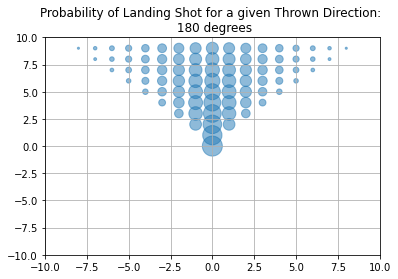

In [7]:
bin_x = 0
bin_y = 0
throw_direction = 180

prob_table = pd.DataFrame()
for i in range(0,20):
    state_x = -10 + i
    for j in range(0,20):
        state_y = -10 + j
        prob = pd.DataFrame({'x':state_x,'y':state_y,'prob':probability(bin_x, bin_y, state_x, state_y, throw_direction)}, index = [0])
        prob_table = prob_table.append(prob)
prob_table = prob_table.reset_index()

plt.scatter(prob_table['x'], prob_table['y'], s=prob_table['prob']*400, alpha=0.5)
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.grid()
plt.title("Probability of Landing Shot for a given Thrown Direction: \n " + str(throw_direction)+" degrees")
plt.show()

        

#### Animated Plot for All Throwing Directions

To demonstrate this further, we can iterate through a number of throwing directions and create an interactive animation. The code becomes a little complex and you can always simply use the prevous code chunk and change the throw_direction manually to explore different positions. However, if you are interested in understanding how the animation is created, you can follow a guide I wrote to do this here:

https://www.philiposbornedata.com/2018/03/01/creating-interactive-animation-for-parameter-optimisation-using-plot-ly/


I will be using simimlar animations later to demonstrate the effect of varying parameters.


In [8]:
bin_x = 0
bin_y = 0

prob_table = pd.DataFrame()
for z in range(0,37):
    throw_direction = z*10
    for i in range(0,20):
        state_x = -10 + i
        for j in range(0,20):
            state_y = -10 + j
            prob = pd.DataFrame({'throw_dir':throw_direction,'x':state_x,'y':state_y,'prob':probability(bin_x, bin_y, state_x, state_y, throw_direction)}, index = [0])
            prob_table = prob_table.append(prob)
prob_table = prob_table.reset_index(drop=True)
        

In [9]:
prob_table.head()

,throw_dir,x,y,prob
0,0,-10,-10,0.0
1,0,-10,-9,0.0
2,0,-10,-8,0.0
3,0,-10,-7,0.0
4,0,-10,-6,0.0


In [10]:
# Create interactive animation to show change of throwing direction to state probabilities (https://www.philiposbornedata.com/2018/03/01/creating-interactive-animation-for-parameter-optimisation-using-plot-ly/)
# This code is only used for visual and can be ignored entirely otherwise
prob_table_2 = prob_table
prob_table_2['continent'] = 'Test'
prob_table_2['country'] = 'Test2'

prob_table_2.columns = ['year', 'lifeExp', 'gdpPercap', 'pop', 'continent', 'country']
prob_table_2 = prob_table_2[prob_table_2['pop']>=0]
prob_table_2['pop'] = prob_table_2['pop']*100000000
prob_table_2.head()
alpha = list(set(prob_table_2['year']))
alpha = np.round(alpha,1)
alpha = np.sort(alpha)#[::-1]
years = np.round([(alpha) for alpha in alpha],1)
years

dataset = prob_table_2

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Probability of Throwing Paper for each State as Thrown Direction Varies <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'range': [-10,10], 'title': 'x'}
figure['layout']['yaxis'] = {'range': [-10,10],'title': 'y', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}

figure['layout']['autosize'] = False
figure['layout']['width'] = 750
figure['layout']['height'] = 750


figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Thrown Direction: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop'])
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': str(year),
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

# iplot to do in notebook or plot to open new tab
iplot(figure)
#plot(figure)

NameError: name 'iplot' is not defined

# Conclusion

